# Mermaid Man and Barnacle Boy

*A Nitrous/IPA Gas-generator driven turbopump project*

Author: Elias Aoubala

Date: 01/12/2024

In [3]:
import numpy as np
import handcalcs.render
import pandas as pd
import matplotlib.pyplot as plt

## 1 - Background

This python notebook outlines all the calculations done by the author in the sizing of the turbine and gas generator stages of the turbopump

## 2 - Key Requirements

This section outlines all the key requirements for the turbine side of the gas generator, as specified by the IPA pump design requirements.

In [53]:
%%render

N = 30000 # rpm

P = 6.464 # kW


<IPython.core.display.Latex object>

Based on these requirements, we can start to size the turbine and gas generator accordingly.

## 3 - MR Selection

One of the first steps that needs to be conducted in the sizing of the two components is to decided what the mixture ratio of the gas generator is. This is mainly driven on material requirements, with a maximum combustion gas temperature being acceptable.

In this case,  we have opted for a maxium gas temperature of the gas generator to be around **800 K**.

We can assume the following chamber conditions for the gas generator

In [5]:
%%render sci_not

P_c = 10e5 # Pa

<IPython.core.display.Latex object>

Based on this, we can conduct a O/F sweep using NASA CEA to see how the combustion temperature varies as a function of combustion conditions. 

We will sweep an O/F from 1 to 5.

Text(0.5, 1.0, 'Variation of Combustion Temperature with MR')

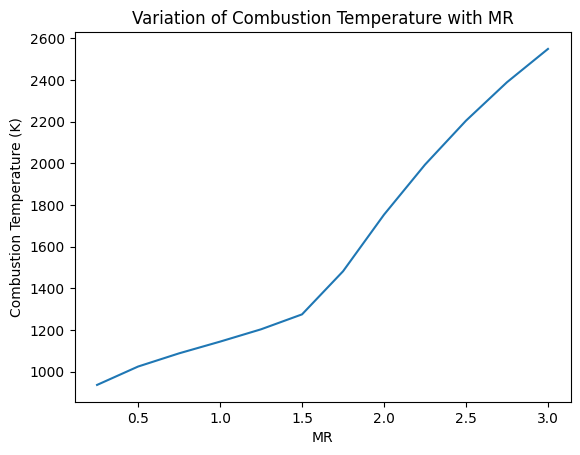

In [6]:
O_F_array = np.arange(0.25, 3 + 0.25, 0.25)

df = pd.read_csv("cea.txt").assign(o_f = O_F_array)

plt.plot(df["o_f"], df["t"])
plt.xlabel("MR")
plt.ylabel("Combustion Temperature (K)")
plt.title("Variation of Combustion Temperature with MR")

As can be seen, the combustion temperatures are significantly higher than we can plausibly accept for any reasonable MR. We must however consider the injector performance, as this normally has second order impacts on the combustion temperature.

c* is defined as the following:

$c^* = \frac{P_c A_t}{\dot{m}}$

We can derive the relationship between c* and the gas temperature to be as follows:

$c^* = \sqrt{\frac{T R}{\gamma} \left( \frac{\gamma + 1}{2} \right) ^{\frac{\gamma + 1}{\gamma -1 }})}$

We can assume thay any efficiency impact has negligible impact to the specific heat ratio of the specific gas constant of the resultant mixture, but only with the combustion temperature. Hence we can derive the following relationship for the $c^*$ efficiency with combustion temperature

$\eta_{c^*} = \frac{c^*_{act}}{c^*_{theo}} = \frac{\sqrt{T_{act}}}{\sqrt{T_{theo}}}$

Thus we can derive the actual combustion temperature as follows:

$T_{act} = T_{theo} \eta_{c^*}^2$

It should be noted that the assumption made that gas composition and specific heat ratio remain constant are unverified and can be gross, but it can be proximate for first pass sizing. The following c* efficiency has been assumed

In [7]:
%%render

eta_c = 0.85

<IPython.core.display.Latex object>

Based on this c* efficiency, we can now back calculate what our new combustion temperatures will be for the gas generators:

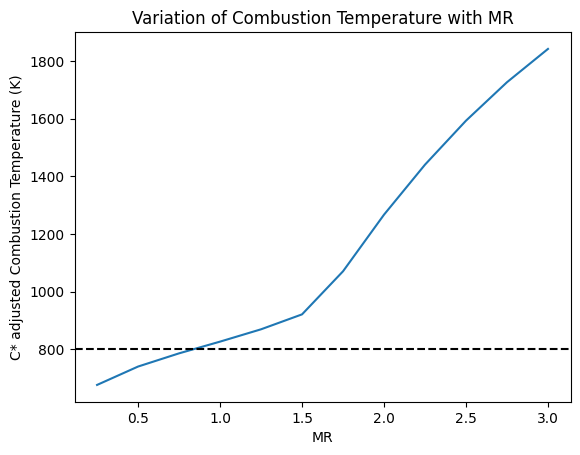

In [8]:
plt.plot(df["o_f"], df["t"] * eta_c**2)
plt.xlabel("MR")
plt.ylabel("C* adjusted Combustion Temperature (K)")
plt.title("Variation of Combustion Temperature with MR")
plt.axhline(800, linestyle="--", color="k")

Based on the above chart, we can base line an O/F of approximately 0.75 for the gas generator.

Now that we know our target set point, we can start to size our turbine wheel and figure out how big a gas generator we actually need to hit the performance metrics needed for the pump.

## 4 - Turbine Sizing

For the Turbine Sizing, we can assume Ideal gas effects for figuring out how much we will need to expand the gas.

The following equation for the specific energy release will be used:

$w = \eta_t \Delta h$

We can employ the ideal gas assumption to further expand this parameter to the following:

$w = \eta_t C_p (T_1 - T_{2s})$

We can further figure out what our isentropic expansion pressure would be accordingly using the following:

$\frac{P_2}{P_1} = \left(  \frac{T_{2s}}{T_1} \right) ^\frac{\gamma}{\gamma - 1}$

where $T_{2s}$ refers to the isentropic expansion temperature.

For the turbine stage efficiency, the following assumptions can be made:

In [9]:
%%render param

eta_t = 0.20 # Efficiency

<IPython.core.display.Latex object>

Based on this we can get an idea of what the required mass flow rates we would need for a given delta in temperature, from which we can see what the turbine expansion pressures needed to be

In [85]:
%%render sci_not
O_F = 0.75

eta_c = eta_c

T_inlet = df.loc[df["o_f"] == O_F]["t"].values[0] * eta_c**2 # K

gamma = df.loc[df["o_f"] == O_F]["gam"].values[0]

cp = df.loc[df["o_f"] == O_F]["cp"].values[0] # kJ/kg K

P_inlet = P_c # Pa


<IPython.core.display.Latex object>

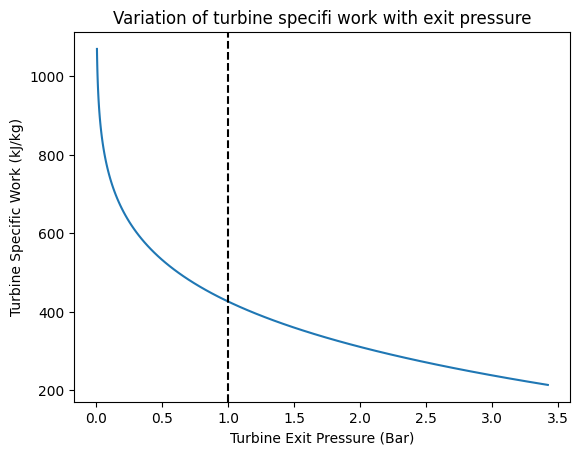

In [87]:
# We need to span different expansion temperatures to see what we


delta_T = np.linspace(100, 500, 100)

T_2s = T_inlet - delta_T

P_expand = P_inlet*(T_2s/T_inlet)**(gamma/(gamma - 1))

w = cp * eta_t * delta_T

plt.plot(P_expand/1e5, w)
plt.xlabel("Turbine Exit Pressure (Bar)")
plt.ylabel("Turbine Specific Work (kJ/kg)")
plt.title("Variation of turbine specifi work with exit pressure")
plt.axvline(1, linestyle="--", color="k")

As we decrease the expansion across the turbine, the turbine specific work drops at quite a significant pace. To quantify the impact this will have on the gas generator sizing interms of total mass flow, we can take our power requirement and calculate what the total required mass flow rate needed is.



In [88]:
%%render sci_not

P_req = P # kw

<IPython.core.display.Latex object>

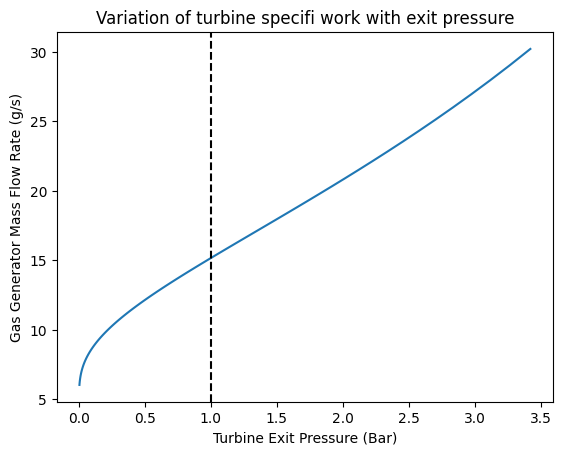

In [89]:
# We need to span different expansion temperatures to see what we

m_dot = P / w

plt.plot(P_expand / 1e5, m_dot*1e3)
plt.xlabel("Turbine Exit Pressure (Bar)")
plt.ylabel("Gas Generator Mass Flow Rate (g/s)")
plt.title("Variation of turbine specifi work with exit pressure")
plt.axvline(1, linestyle="--", color="k")

Based on the graph, we can see that as we want to expand further from the ambient enviroment, the requirements for the gas generator increase approximately linearly. What we can suggest is we select a turbine exit pressure with a comfortable margin to allow for downstream optimisation of the gas generator